In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from utils import train_and_validate_model, BertweetBaseMLP

seed = 42
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
device

device(type='cuda')

Let's import the files developed in the preprocessing part.

# Training

In [2]:
file_path = "aggregated_embeddings_with_labels.pkl"
merged_df = pd.read_pickle(file_path)
X = np.vstack(merged_df["aggregated_embedding"].values)
y = merged_df["EventType"].values

In [3]:
merged_df

,ID,aggregated_embedding,EventType
0,0_0,"[0.038894046, 0.2056955, 0.1732219, -0.0507800...",0
1,0_1,"[0.049072143, 0.20504853, 0.16913632, -0.04101...",0
2,0_10,"[-0.010199165, 0.19084008, 0.142129, -0.027013...",1
3,0_100,"[0.1076907, 0.18990463, 0.13662358, -0.0059914...",1
4,0_101,"[0.110753596, 0.21662608, 0.14855266, -0.02414...",1
...,...,...,...
2132,8_95,"[-0.12547426, 0.10333069, 0.012717849, 0.00890...",0
2133,8_96,"[-0.13536794, 0.08814793, 0.013134736, -0.0146...",1
2134,8_97,"[-0.13311367, 0.09247862, 0.016269028, 0.00072...",1
2135,8_98,"[-0.12481897, 0.07730664, 0.014376387, 0.00727...",0


In [4]:
X

array([[ 0.03889405,  0.2056955 ,  0.1732219 , ..., -0.16008152,
        -0.07019368, -0.06282356],
       [ 0.04907214,  0.20504853,  0.16913632, ..., -0.15363938,
        -0.04890908, -0.06128334],
       [-0.01019916,  0.19084008,  0.142129  , ..., -0.11866952,
        -0.05552096, -0.09124397],
       ...,
       [-0.13311367,  0.09247862,  0.01626903, ..., -0.10107715,
        -0.03391625, -0.13359854],
       [-0.12481897,  0.07730664,  0.01437639, ..., -0.10100207,
        -0.02210176, -0.1194981 ],
       [-0.13261126,  0.08881129,  0.01706956, ..., -0.11458072,
        -0.02714121, -0.13340919]], dtype=float32)

In [5]:
y

array([0, 0, 1, ..., 1, 0, 1], dtype=int64)

In [6]:
merged_df["EventType"].value_counts()

EventType
1    1153
0     984
Name: count, dtype: int64

The class imbalance is negligible, which is good.

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [8]:
X_train.shape, X_val.shape

((1709, 768), (428, 768))

In [9]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

In [10]:
X_train_tensor.shape, X_val_tensor.shape

(torch.Size([1709, 768]), torch.Size([428, 768]))

In [11]:
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [39]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
embedding_dim = X_train_tensor.shape[1]
mlp = BertweetBaseMLP(embedding_dim)
mlp = mlp.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(mlp.parameters(), lr=1e-5, weight_decay=1e-5)

In [40]:
epochs = 1000
history = train_and_validate_model(mlp, train_loader, val_loader, criterion, optimizer, device, epochs, seed, use_tqdm=False)

Epoch 1/1000
Training Loss: 0.7306, Accuracy: 0.5126
Validation Loss: 0.6918, Accuracy: 0.5397
Epoch 2/1000
Training Loss: 0.7073, Accuracy: 0.5471
Validation Loss: 0.6892, Accuracy: 0.6098
Epoch 3/1000
Training Loss: 0.6920, Accuracy: 0.5682
Validation Loss: 0.6781, Accuracy: 0.6332
Epoch 4/1000
Training Loss: 0.6799, Accuracy: 0.5699
Validation Loss: 0.6650, Accuracy: 0.6402
Epoch 5/1000
Training Loss: 0.6803, Accuracy: 0.5670
Validation Loss: 0.6577, Accuracy: 0.6449
Epoch 6/1000
Training Loss: 0.6693, Accuracy: 0.5828
Validation Loss: 0.6546, Accuracy: 0.6402
Epoch 7/1000
Training Loss: 0.6728, Accuracy: 0.5723
Validation Loss: 0.6507, Accuracy: 0.6659
Epoch 8/1000
Training Loss: 0.6556, Accuracy: 0.5910
Validation Loss: 0.6466, Accuracy: 0.6565
Epoch 9/1000
Training Loss: 0.6586, Accuracy: 0.6044
Validation Loss: 0.6440, Accuracy: 0.6519
Epoch 10/1000
Training Loss: 0.6508, Accuracy: 0.6132
Validation Loss: 0.6390, Accuracy: 0.6449
Epoch 11/1000
Training Loss: 0.6470, Accuracy: 0.

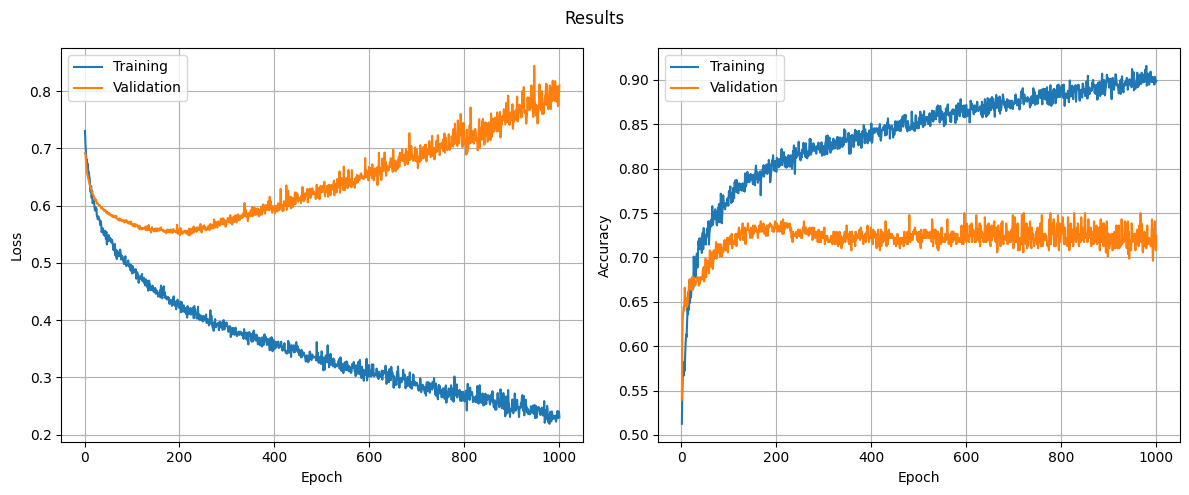

In [41]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), history["train_loss"], label='Training')
plt.plot(range(1, epochs + 1), history["val_loss"], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), history["train_accuracy"], label='Training')
plt.plot(range(1, epochs + 1), history["val_accuracy"], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.suptitle("Results")
plt.tight_layout()
plt.show()

After experimenting a bit, it seems like the (sub)optimal model is the one using Adam with learning rate 1e-5 and weight decay 1e-5. Moreover, it seems like a good stopping point is at 200, after which we observe overfitting. 

In [43]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
mlp_final = BertweetBaseMLP(embedding_dim)
mlp_final = mlp_final.to(device)
optimizer_final = optim.AdamW(mlp_final.parameters(), lr=1e-5, weight_decay=1e-5)

In [44]:
epochs = 200
history_final = train_and_validate_model(mlp_final, train_loader, val_loader, criterion, optimizer_final, device, epochs, seed, use_tqdm=False)

Epoch 1/200
Training Loss: 0.7306, Accuracy: 0.5126
Validation Loss: 0.6918, Accuracy: 0.5397
Epoch 2/200
Training Loss: 0.7073, Accuracy: 0.5471
Validation Loss: 0.6892, Accuracy: 0.6098
Epoch 3/200
Training Loss: 0.6920, Accuracy: 0.5682
Validation Loss: 0.6781, Accuracy: 0.6332
Epoch 4/200
Training Loss: 0.6799, Accuracy: 0.5699
Validation Loss: 0.6650, Accuracy: 0.6402
Epoch 5/200
Training Loss: 0.6803, Accuracy: 0.5670
Validation Loss: 0.6577, Accuracy: 0.6449
Epoch 6/200
Training Loss: 0.6693, Accuracy: 0.5828
Validation Loss: 0.6546, Accuracy: 0.6402
Epoch 7/200
Training Loss: 0.6728, Accuracy: 0.5723
Validation Loss: 0.6507, Accuracy: 0.6659
Epoch 8/200
Training Loss: 0.6556, Accuracy: 0.5910
Validation Loss: 0.6466, Accuracy: 0.6565
Epoch 9/200
Training Loss: 0.6586, Accuracy: 0.6044
Validation Loss: 0.6440, Accuracy: 0.6519
Epoch 10/200
Training Loss: 0.6508, Accuracy: 0.6132
Validation Loss: 0.6390, Accuracy: 0.6449
Epoch 11/200
Training Loss: 0.6470, Accuracy: 0.6103
Valida

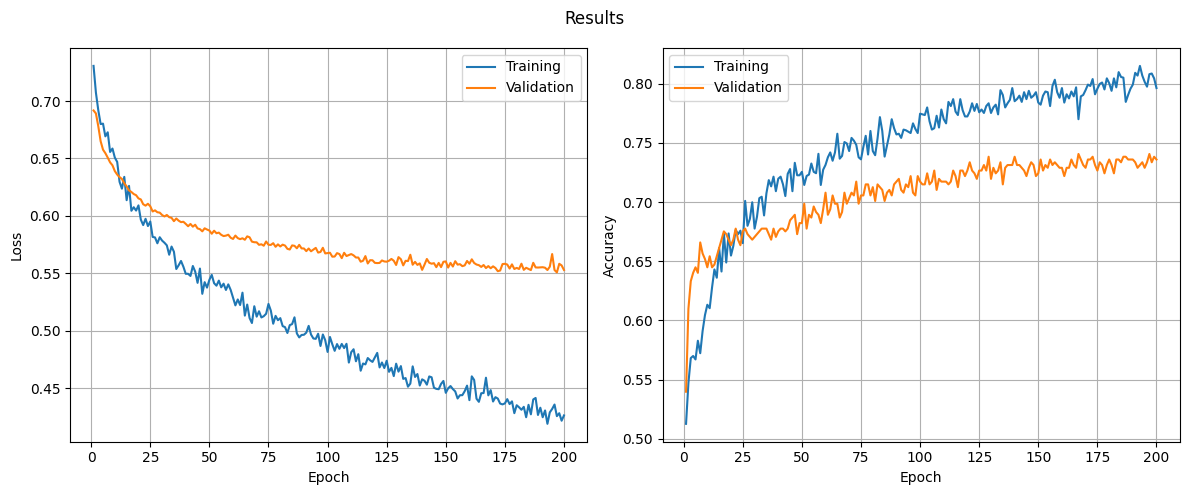

In [46]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), history_final["train_loss"], label='Training')
plt.plot(range(1, epochs + 1), history_final["val_loss"], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), history_final["train_accuracy"], label='Training')
plt.plot(range(1, epochs + 1), history_final["val_accuracy"], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.suptitle("Results")
plt.tight_layout()
plt.show()

In [47]:
torch.save(mlp_final.state_dict(), "bertweet_base_model.pt")

# Testing

Let's test the model for the submission.

In [52]:
file_path = "aggregated_embeddings_with_labels_test.pkl"
merged_df_test = pd.read_pickle(file_path)
X_test = np.vstack(merged_df_test["aggregated_embedding"].values)

In [53]:
merged_df_test

,ID,aggregated_embedding,MatchID
0,15_0,"[-0.005626861, 0.17002444, 0.1560707, -0.07122...",15
1,15_1,"[-0.012398133, 0.16987626, 0.15416442, -0.0715...",15
2,15_10,"[-0.0063685165, 0.17705764, 0.14571677, -0.061...",15
3,15_100,"[-0.028167112, 0.21267831, 0.11889246, -0.0327...",15
4,15_101,"[-0.021408508, 0.20869574, 0.12005638, -0.0342...",15
...,...,...,...
511,9_95,"[-0.06389925, 0.15774356, 0.10894526, -0.06712...",9
512,9_96,"[-0.06254904, 0.16254315, 0.10645582, -0.07547...",9
513,9_97,"[-0.06544371, 0.15834767, 0.1077392, -0.078381...",9
514,9_98,"[-0.061433755, 0.15302086, 0.0968332, -0.06357...",9


In [54]:
X_test.shape

(516, 768)

In [55]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

In [56]:
# embedding_dim = X_test.shape[1]
# mlp_final = BertweetBaseMLP(embedding_dim)
# mlp_final.load_state_dict(torch.load("bertweet_base_model.pt"))
# mlp_final = mlp_final.to(device)

In [57]:
mlp_final.eval()
with torch.no_grad():
    logits = mlp_final(X_test_tensor).squeeze()  
    predictions = (torch.sigmoid(logits) >= 0.5).int().cpu().numpy()

In [58]:
final_df = pd.DataFrame({
    "ID": merged_df_test["ID"],
    "EventType": predictions  # Add predictions as EventType
})

In [59]:
final_df

,ID,EventType
0,15_0,0
1,15_1,0
2,15_10,0
3,15_100,1
4,15_101,1
...,...,...
511,9_95,0
512,9_96,0
513,9_97,0
514,9_98,1


In [60]:
final_df.to_csv("bertweet_base_predictions.csv", index=False)